# Hand Label Analysis
This notebook contains and analysis of the expert annotated notebooks used to evaluate CORAL.

In [1]:
import pandas as pd
import glob

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

pd.options.mode.chained_assignment = None 

In [2]:
READABLE_LABELS = ["STAGE_PAD","WRANGLE","EXPLORE","MODEL","EVALUATE","IMPORT"]
ORDERED_LABELS = ["IMPORT","WRANGLE","EXPLORE","MODEL","EVALUATE","STAGE_PAD"]
READABLE_LABEL_TO_INT = dict(zip(READABLE_LABELS,range(len(READABLE_LABELS))))
DEMO_LOC = "http://quackerjack.cs.washington.edu:5000/annotatenb/"

In [3]:
def path_to_nb_id(path):
    filename = path.split("/")[-1]
    no_ext = filename.split(".")[0]
    no_prefix = no_ext.split("_")[-1]
    return int(no_prefix)

def get_hand_labels(path,labeler=None):
    labeled_jsons = glob.glob(path)
    results = []
    for path in labeled_jsons:
        nb_id = path_to_nb_id(path)
        notebook = pd.read_json(path)
        notebook = notebook[notebook["stage"]!=READABLE_LABEL_TO_INT["STAGE_PAD"]]
        notebook["cell_no"] = notebook.index
        notebook["nb_id"] = nb_id
        results.append(notebook[["nb_id","cell_no","stage","source"]])
    results = pd.concat(results,axis=0)
    if labeler:
        results[labeler+"_label"] = results["stage"]
        del results["stage"]
    return results

mike_labels = get_hand_labels("/projects/bdata/jupyter/annotation/mike/*.json",
                             labeler = "Mike")
ge_labels = get_hand_labels("/projects/bdata/jupyter/annotation/ge/*.json",
                             labeler = "Ge")

In [4]:
all_labels = pd.merge(mike_labels,ge_labels, on = ["nb_id","cell_no"],how = "outer")

In [5]:
len(all_labels)

1829

In [6]:
all_labels["Mike_label"].value_counts()

2.0    767
1.0    558
3.0    213
5.0    136
4.0    117
Name: Mike_label, dtype: int64

Looks like there are a few cells I didn't label?

In [7]:
all_labels = all_labels.dropna(subset = ["Ge_label","Mike_label"])

In [8]:
cohen_kappa_score(all_labels["Mike_label"],all_labels["Ge_label"])

0.63204034302881

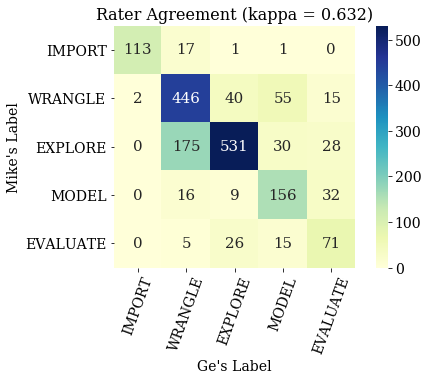

In [9]:
def plot_stage_confusion_matrix(y_1,y_2,y_label = "y_1", x_label = "y_2",ax=None,cbar=True,
                               yticklabels='auto', vmax=None):
    conf_mtx = pd.DataFrame(confusion_matrix(y_1, y_2),
                columns=READABLE_LABELS[1:],
                index = READABLE_LABELS[1:])
    conf_mtx.index = pd.CategoricalIndex(conf_mtx.index, categories= ORDERED_LABELS[:-1])
    conf_mtx.sort_index(level=0, inplace=True)

    conf_mtx.columns = pd.CategoricalIndex(conf_mtx.columns, categories= ORDERED_LABELS[:-1])
    conf_mtx.sort_index(axis=1,inplace = True)
    ax = sns.heatmap(conf_mtx,annot=True,fmt="d", square = True, ax = ax, cbar = cbar,
               yticklabels=yticklabels,vmax=vmax,cmap="YlGnBu")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
 
with plt.style.context("publications.mplstyle"):
    plot_stage_confusion_matrix(all_labels["Mike_label"], all_labels["Ge_label"],
                               x_label = "Ge's Label", y_label = "Mike's Label")
    plt.title("Rater Agreement (kappa = 0.632)")
    

In [10]:
len(all_labels[(all_labels["Mike_label"] == 2) & (all_labels["Ge_label"] ==1)])

175

Here's one example where Ge and I disagree, from nb `1043186`. I say explore, she says wrangle.


And another:

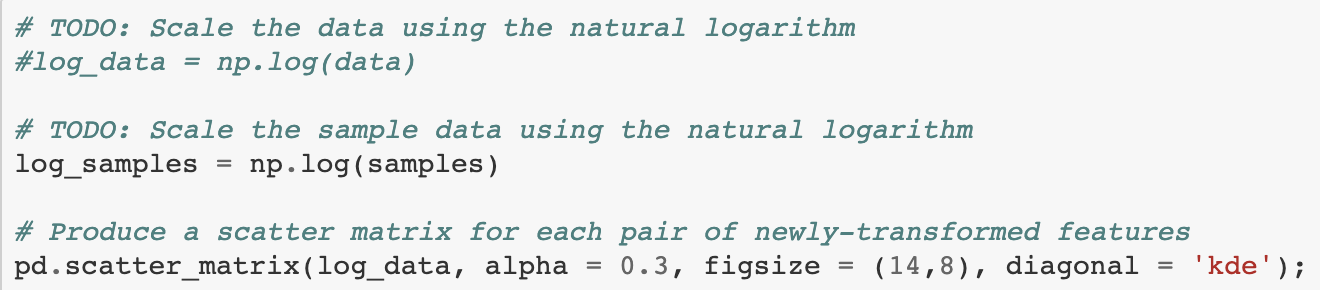

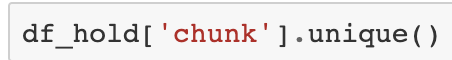

In [11]:
import matplotlib
matplotlib.get_configdir()

'/homes/gws/mikeam/.config/matplotlib'

# Disagreements:

In [12]:
disagreements = all_labels[all_labels["Mike_label"] != all_labels["Ge_label"]]
len(disagreements)

467

In [13]:
disagreements.loc[:,"Mike_label_readable"] = disagreements["Mike_label"].map(lambda x: READABLE_LABELS[int(x)])
disagreements.loc[:,"Ge_label_readable"] = disagreements["Ge_label"].map(lambda x: READABLE_LABELS[int(x)])

# Second Round of Labeling

In [14]:
mike_labels_v2 = get_hand_labels("/projects/bdata/jupyter/annotation/version_2/mike/*.json",
                             labeler = "Mike")
ge_labels_v2 = get_hand_labels("/projects/bdata/jupyter/annotation/version_2/ge/*.json",
                             labeler = "Ge")

all_labels_v2 = pd.merge(mike_labels_v2,ge_labels_v2, on = ["nb_id","cell_no"],how = "outer")
all_labels_v2 = all_labels_v2.dropna(subset = ["Ge_label","Mike_label"])
kappa_v2 = cohen_kappa_score(all_labels_v2["Mike_label"],all_labels_v2["Ge_label"])
kappa_v2

0.8026369250225349

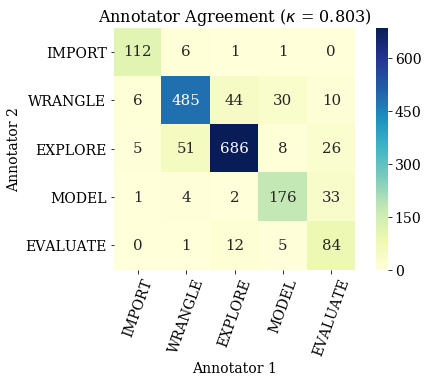

In [15]:
with plt.style.context("publications.mplstyle"):
    plot_stage_confusion_matrix(all_labels_v2["Mike_label"], all_labels_v2["Ge_label"],
                               x_label = "Annotator 1", y_label = "Annotator 2")
    plt.title("Annotator Agreement ($\kappa$ = {0:.3f})".format(kappa_v2))
    plt.savefig("figs/annotator_agreement.pdf", bbox_inches="tight",transparent = True)

In [16]:
disagreements_v2 = all_labels_v2[all_labels_v2["Mike_label"] != all_labels_v2["Ge_label"]]
print("Number of disagreements:", len(disagreements_v2))
print("Number of notebooks to re-label:", disagreements_v2["nb_id"].nunique())

disagreements_v2["Mike_label_readable"] = disagreements_v2["Mike_label"].map(lambda x: READABLE_LABELS[int(x)])
disagreements_v2["Ge_label_readable"] = disagreements_v2["Ge_label"].map(lambda x: READABLE_LABELS[int(x)])
disagreements_v2["nb_link"] = DEMO_LOC + "nb_" + disagreements_v2["nb_id"].astype(str) + ".ipynb"

export_cols = ["nb_link","nb_id","cell_no","source_x","Mike_label_readable","Ge_label_readable"]
disagreements_v2.sort_values(["nb_id","cell_no"])[export_cols].to_csv("disagreements_v2.csv")

Number of disagreements: 246
Number of notebooks to re-label: 69


In [17]:
len(disagreements_v2)

246

# Additional Error Analysis

In [27]:
pred_labels = pd.read_json("/projects/bdata/jupyter/results/annotation/graphs_11.txt", lines = True)

In [28]:
pred_labels.head()

,target_lineno,file,context,target_func,nodes,funcs,stage,id,neighbor_cells,header,annotation,new_nodes,idx_map,pred,stage_vec
0,183,/projects/bdata/jupyter/_7_1/nb_1053523.py,\nx0 = [x[0] for x in train]\n\nx1 = [x[1] for...,none_func,"[{'type': 'Module', 'children': [1, 11, 21, 36...","[matplotlib.cm.jet, max, matplotlib.pyplot.fig...",2,74,[73],PCA to 150 dimensional space,[],"[Module, Assign, x, 0, ListComp, SubscriptLoad...","{'0': [0], '1': [1], '2': [2, 3], '3': [4], '4...",2,"[-2.149143695831299, -2.429313898086548, 30.93..."
1,61,/projects/bdata/jupyter/_7_1/nb_1170705.py,\nnum_topics = 20\n\nnum_top_words = 20\n\nclf...,none_func,"[{'type': 'Module', 'children': [1, 4, 7, 17, ...","[sklearn.decomposition.NMF, sklearn.decomposit...",3,424,[423],[EMPTY],[],"[Module, Assign, num, topics, 20, Assign, num,...","{'0': [0], '1': [1], '2': [2, 3], '3': [4], '4...",3,"[-2.989803314208984, -1.214049339294433, 4.552..."
2,9,nb_1221634,\nfor i in stems:\n if (len(stems[i][0]) ==...,none_func,"[{'type': 'Module', 'children': [1, 49]}, {'ty...","[len, len]",1,156,[-1],,[],"[Module, For, i, stems, body, If, CompareEq, C...","{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",1,"[-6.59837007522583, 23.175315856933594, 0.5943..."
3,10,/projects/bdata/jupyter/_7_1/nb_1185862.py,\nfile = open('C:/Users/Inance/Documents/Thesi...,none_func,"[{'type': 'Module', 'children': [1, 6, 9, 28, ...","[open, append, float, line.split, numpy.array,...",1,18,[17],Import Libraries,[],"[Module, Assign, file, Call, open, c:, users, ...","{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",2,"[-3.463528394699096, 10.72555923461914, 26.439..."
4,14,/projects/bdata/jupyter/_7_1/nb_1215903.py,\nrng = np.random.RandomState(0)\n\nn_samples_...,none_func,"[{'type': 'Module', 'children': [1, 10, 13, 16...","[numpy.random.RandomState, numpy.random.Random...",1,299,[298],[EMPTY],[],"[Module, Assign, rng, Call, AttributeLoad, Att...","{'0': [0], '1': [1], '2': [2], '3': [3], '4': ...",1,"[-6.39727783203125, 24.1392822265625, 1.701260..."


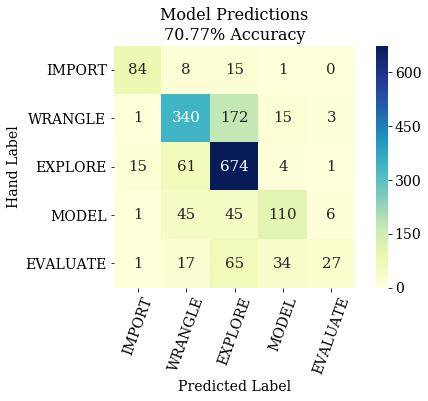

In [32]:
with plt.style.context("publications.mplstyle"):
    g = plot_stage_confusion_matrix(pred_labels["stage"], pred_labels["pred"],x_label = "Predicted Label",
                                y_label = "Hand Label")
    
    plt.title("Model Predictions\n70.77% Accuracy")
    plt.savefig("figs/model_confusion.pdf",bbox_inches="tight",transparent = True)
    

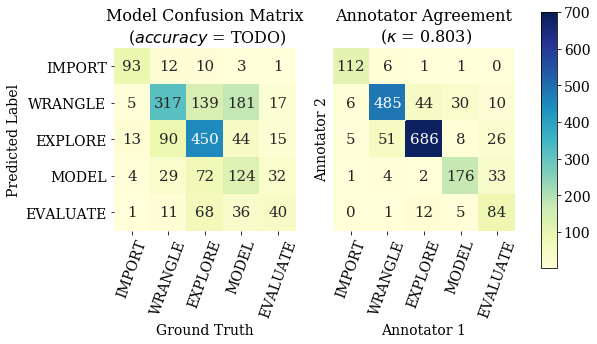

In [21]:
with plt.style.context("publications.mplstyle"):
    fig, axn = plt.subplots(1, 2)

    ax1, ax2 = axn
    plot_stage_confusion_matrix(pred_labels["stage"], pred_labels["pred"],x_label = "Predicted Label",
                                y_label = "Hand Label", ax=ax1, cbar = None,
                                vmax = 700 )
    ax1.title.set_text("Model Confusion Matrix\n ($accuracy$ = TODO)")
    ax1.set_ylabel("Predicted Label")
    ax1.set_xlabel("Ground Truth")
    
    
    plot_stage_confusion_matrix(all_labels_v2["Mike_label"], all_labels_v2["Ge_label"],
                               x_label = "Annotator 1", y_label = "Annotator 2", ax =ax2, 
                               cbar = None, yticklabels=False,vmax=700)
    ax2.title.set_text("Annotator Agreement\n ($\kappa$ = {0:.3f})".format(kappa_v2))
    
    cbaxes = fig.add_axes([0.95, 0.1, 0.03, 0.8]) 
    plt.colorbar(ax1.get_children()[0], ax = [ax1,ax2],
                cax = cbaxes)
#     plt.tight_layout()
plt.savefig("figs/annotator_agreement.pdf", bbox_inches="tight",transparent = True)

# Softmax Correlation

In [22]:
softmax = np.array(pred_labels["stage_vec"].tolist())

Text(0.5, 1, 'Softmax Correlation')

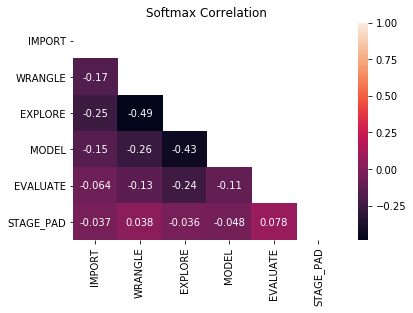

In [23]:
softmax_corr = pd.DataFrame(softmax, columns=READABLE_LABELS).corr()

softmax_corr.index = pd.CategoricalIndex(softmax_corr.index, categories= ORDERED_LABELS)
softmax_corr.sort_index(level=0, inplace=True)

softmax_corr.columns = pd.CategoricalIndex(softmax_corr.columns, categories= ORDERED_LABELS)
softmax_corr.sort_index(axis=1,inplace = True)

mask = np.zeros_like(softmax_corr.values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(softmax_corr,annot=True,mask = mask)
plt.title("Softmax Correlation")

In [24]:
softmax_corr

,IMPORT,WRANGLE,EXPLORE,MODEL,EVALUATE,STAGE_PAD
IMPORT,1.000000,-0.171171,-0.250193,-0.150629,-0.063531,-0.036623
WRANGLE,-0.171171,1.000000,-0.486024,-0.261452,-0.127224,0.038304
EXPLORE,-0.250193,-0.486024,1.000000,-0.434119,-0.240195,-0.035954
MODEL,-0.150629,-0.261452,-0.434119,1.000000,-0.107188,-0.047995
EVALUATE,-0.063531,-0.127224,-0.240195,-0.107188,1.000000,0.078240
STAGE_PAD,-0.036623,0.038304,-0.035954,-0.047995,0.078240,1.000000
